In [22]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.animation as animation
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)

True
12.4
2.4.1+cu124


In [3]:
dataroot = "data/celeba"
numberofEpochs = 20
workers = 2
batchSize = 128
imageSize = 64
numberofChannels = 3
latentVector = 100
generatorFeatureMaps = 64
discriminatorFeatureMaps = 64
learningRateGenerator = 0.0002
learningRateDiscriminator = 0.0002
beta1 = 0.5

In [4]:
dataset = dsets.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize(imageSize), 
    transforms.CenterCrop(imageSize),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

dataloader = DataLoader(dataset, batch_size = batchSize, shuffle=True, num_workers=workers)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

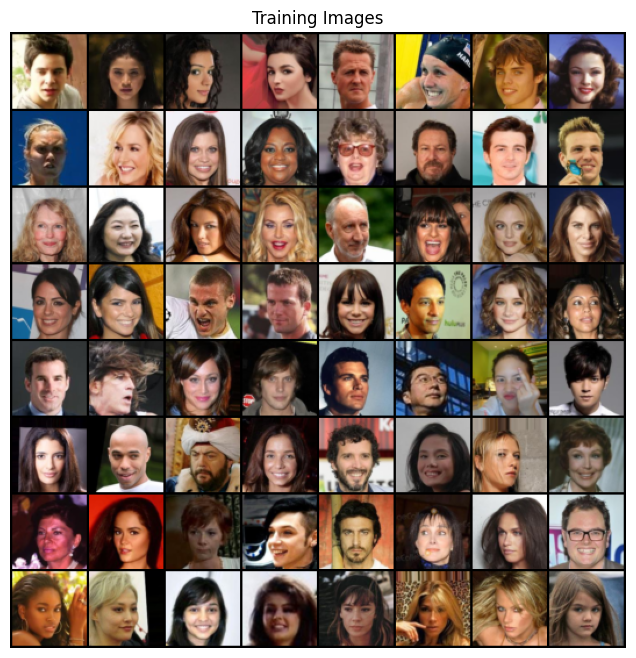

In [6]:
realBatch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(realBatch[0].to(device)[:64], padding = 2, 
                                         normalize = True, nrow = 8).cpu(), (1, 2, 0)))
plt.show()

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latentVector, generatorFeatureMaps * 8, 4, 1, 0, bias = False), 
            nn.BatchNorm2d(generatorFeatureMaps * 8), 
            nn.ReLU(True), 

            nn.ConvTranspose2d(generatorFeatureMaps * 8, generatorFeatureMaps * 4, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(generatorFeatureMaps * 4, generatorFeatureMaps * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128), 
            nn.ReLU(True), 

            nn.ConvTranspose2d(generatorFeatureMaps * 2, generatorFeatureMaps, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(64), 
            nn.ReLU(True),

            nn.ConvTranspose2d(generatorFeatureMaps, numberofChannels, 4, 2, 1, bias = False), 
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [9]:
netGenerator = Generator().to(device)
netGenerator = nn.DataParallel(netGenerator, list(range(1)))
netGenerator.apply(weights_init)
print(netGenerator)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(numberofChannels, discriminatorFeatureMaps, 4, 2, 1, bias = False), 
            nn.LeakyReLU(0.2, inplace = True), 

            nn.Conv2d(discriminatorFeatureMaps, discriminatorFeatureMaps * 2, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True), 

            nn.Conv2d(discriminatorFeatureMaps * 2, discriminatorFeatureMaps * 4, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(discriminatorFeatureMaps * 4, discriminatorFeatureMaps * 8, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace = True), 

            nn.Conv2d(discriminatorFeatureMaps * 8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)    

In [11]:
netDiscriminator = Discriminator().to(device)
netDiscriminator = nn.DataParallel(netDiscriminator, list(range(1)))
netDiscriminator.apply(weights_init)
print(netDiscriminator)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

In [12]:
criterion = nn.BCELoss()

fixedNoise = torch.randn(64, latentVector, 1, 1, device = device)

realLabel = 1
fakeLabel = 0

optimizerDiscriminator = optim.Adam(netDiscriminator.parameters(), lr = learningRateDiscriminator, betas = (beta1, 0.999))
optimizerGenerator = optim.Adam(netGenerator.parameters(), lr = learningRateGenerator, betas = (beta1, 0.999))

In [13]:
imageList = []
generatorLosses = []
discriminatorLosses = []
iters = 0

for epoch in range(numberofEpochs):
    for i, data in enumerate(dataloader, 0):
        netDiscriminator.zero_grad()
        realData = data[0].to(device)
        batchSize = realData.size(0)
        label = torch.full((batchSize,), realLabel, dtype = torch.float, device = device)
        output = netDiscriminator(realData).view(-1)
        errorDReal = criterion(output, label)
        errorDReal.backward()
        D_x = output.mean().item()

        noise = torch.randn(batchSize, latentVector, 1, 1, device = device)
        fake = netGenerator(noise)
        label.fill_(fakeLabel)
        output = netDiscriminator(fake.detach()).view(-1)
        errorDFake = criterion(output, label)
        errorDFake.backward()
        D_G_z1 = output.mean().item()
        errorD = errorDReal + errorDFake
        optimizerDiscriminator.step()

        netGenerator.zero_grad()
        label.fill_(realLabel)
        output = netDiscriminator(fake).view(-1)
        errorG = criterion(output, label)
        errorG.backward()
        D_G_z2 = output.mean().item()
        optimizerGenerator.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, numberofEpochs, i, len(dataloader), errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        generatorLosses.append(errorG.item())
        discriminatorLosses.append(errorD.item())

        if (iters % 500 == 0) or ((epoch == numberofEpochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netGenerator(fixedNoise).detach().cpu()
            imageList.append(vutils.make_grid(fake, padding = 2, normalize = True))

        iters += 1



[0/20][0/1583]	Loss_D: 1.7654	Loss_G: 2.5181	D(x): 0.3301	D(G(z)): 0.3128 / 0.1100
[0/20][50/1583]	Loss_D: 0.3460	Loss_G: 24.8203	D(x): 0.8544	D(G(z)): 0.0000 / 0.0000
[0/20][100/1583]	Loss_D: 0.2520	Loss_G: 5.8603	D(x): 0.9665	D(G(z)): 0.1359 / 0.0182
[0/20][150/1583]	Loss_D: 0.3741	Loss_G: 5.2882	D(x): 0.7758	D(G(z)): 0.0212 / 0.0100
[0/20][200/1583]	Loss_D: 0.2805	Loss_G: 4.4015	D(x): 0.9012	D(G(z)): 0.1367 / 0.0253
[0/20][250/1583]	Loss_D: 0.3505	Loss_G: 5.6436	D(x): 0.9068	D(G(z)): 0.1653 / 0.0101
[0/20][300/1583]	Loss_D: 0.5196	Loss_G: 3.8047	D(x): 0.8561	D(G(z)): 0.2565 / 0.0403
[0/20][350/1583]	Loss_D: 0.6118	Loss_G: 2.1909	D(x): 0.6797	D(G(z)): 0.1049 / 0.1491
[0/20][400/1583]	Loss_D: 0.2116	Loss_G: 5.7241	D(x): 0.9514	D(G(z)): 0.1376 / 0.0056
[0/20][450/1583]	Loss_D: 0.7865	Loss_G: 3.7229	D(x): 0.6015	D(G(z)): 0.0637 / 0.0412
[0/20][500/1583]	Loss_D: 0.5751	Loss_G: 4.0436	D(x): 0.6833	D(G(z)): 0.0375 / 0.0307
[0/20][550/1583]	Loss_D: 0.5460	Loss_G: 4.7358	D(x): 0.8149	D(G(z))

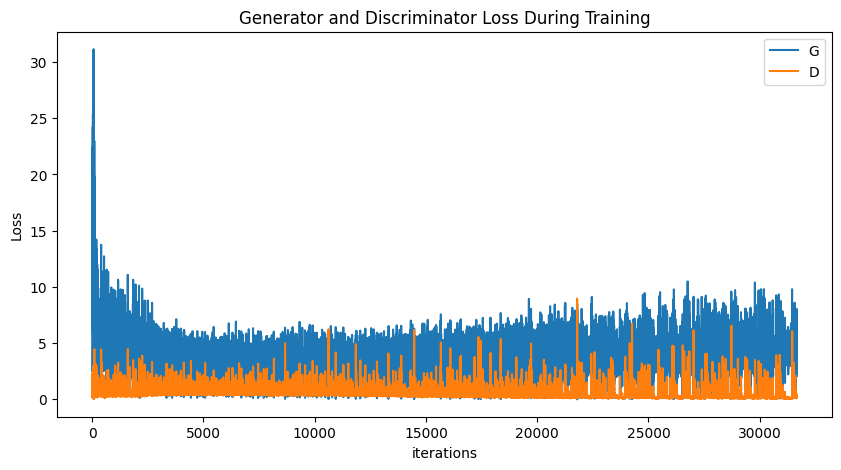

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generatorLosses, label="G")
plt.plot(discriminatorLosses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Animation size has reached 21066995 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


Animation saved as FakeCelebrities/animation.html


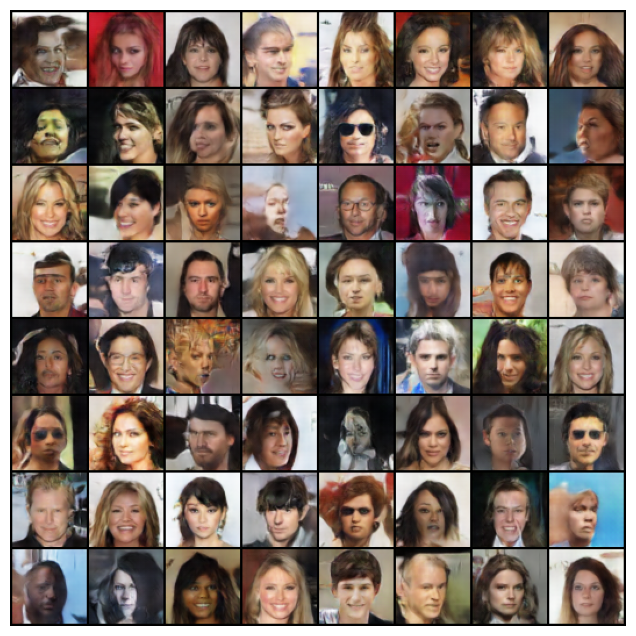

In [16]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in imageList]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

htmlContent = ani.to_jshtml()

filePath = 'FakeCelebrities/animation.html'
os.makedirs(os.path.dirname(filePath), exist_ok=True)

with open(filePath, 'w') as f:
    f.write(htmlContent)

print(f"Animation saved as {filePath}")

In [27]:
os.makedirs("SavedImages", exist_ok=True)

for idx, img in enumerate(imageList):
    img_transposed = np.transpose(img.numpy(), (1, 2, 0)) 
    img_transposed = (img_transposed * 255).astype(np.uint8)  
    plt.imsave(f"SavedImages/image{idx}.png", img_transposed)

imageFiles = [f"SavedImages/image{i}.png" for i in range(len(imageList))]
images = [Image.open(img) for img in imageFiles]

images[0].save('SavedImages/animation.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)

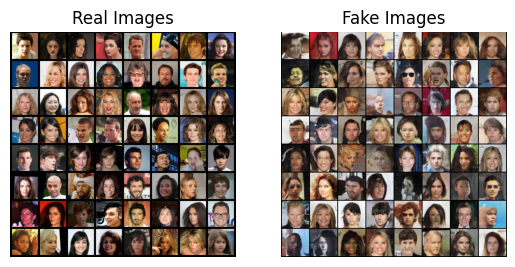

In [28]:
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(realBatch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(imageList[-1],(1,2,0)))
plt.show()
    